# Computer Vision (911.908)

## <font color='crimson'>Gradient-based optimization</font>

**Changelog**:
- *Sep. 2020*: initial version (using PyTorch v1.6) 
- *Sep. 2021*: adaptations to PyTorch v1.9
- *Nov. 2022*: adaptations to PyTorch v1.21.1 + minor fixes

In this lecture, we look at the method of **gradient-descent** for minimization problems.

---

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt

import sys
import torch
import numpy as np
from torch.autograd import grad

sys.path.append('./')

from utils import clean
from utils import parula_map

---

## Content

- [Preliminaries](#Preliminaries)
- [Gradient descent](#Gradient-descent)

---

<img src="motivation.png" width="800" height="400">

## Preliminaries

Suppose that $f$ is a real-valued continuously differentiable function defined on some open set in $\mathbb{R}^n$. Let $\mathbf{x}$ be a point in the domain of $f$ and $\mathbf{u}$ a unit vector, i.e., a vector of length $\|\mathbf{u}\|= \sqrt{\langle \mathbf{u},\mathbf{u}\rangle} = 1$.

The **directional derivative** of $f$ at $\mathbf{x}$ in the direction of $\mathbf{u}$ is given by

$$
D_{\mathbf{u}}f(\mathbf{x}) = \left[ \frac{d}{ds} f(\mathbf{x}+s\mathbf{u}) \right]_{s=0}
$$

It gives us the **rate of change** of the function in the direction of the unit vector $\mathbf{u}$.

One property of directional derivatives is

$$D_{-\mathbf{u}}f(\mathbf{x}) = -D_{\mathbf{u}}f(\mathbf{x})$$

Using the chain rule, we also get the following equality:

\begin{align*}
\frac{d}{ds}f(\mathbf{x}+s\mathbf{u}) & = \sum_i \frac{\partial f}{\partial x_i}(\mathbf{x}+s\mathbf{u}) \frac{d}{ds}(x_i + su_i) \\
& = \sum_i \frac{\partial f}{\partial x_i}(\mathbf{x}+s\mathbf{u}) u_i
\end{align*}
which, upon taking the limit $s \to 0$ gives

$$
D_{\mathbf{u}}f(\mathbf{x}) = \sum_i \frac{\partial f}{\partial x_i}(\mathbf{x})u_i
$$

Remember that the **gradient** of $f$ at $\mathbf{x}$ is defined as

$$
\nabla f(\mathbf{x}) = \left[\frac{\partial f}{\partial x_1}f(\mathbf{x}), \ldots \frac{\partial f}{\partial x_n}f(\mathbf{x}) \right]^\top\enspace.
$$

Hence, we can write the directional derivative as

$$
D_{\mathbf{u}} f(\mathbf{x}) = \langle \nabla f(\mathbf{x}), \mathbf{u} \rangle = \|\nabla f(\mathbf{x})\| \|\mathbf{u}\|\cos(\theta)
$$

where $\theta$ denotes the angle between $\nabla f(\mathbf{x})$ and $\mathbf{u}$. Hence, we can write the directional derivative of $f$ along the unit vector $\mathbf{u}$ as the inner product between the gradient of $f$ and $\mathbf{u}$. Also, since $\|\mathbf{u}\|=1$, we have 

$$
D_{\mathbf{u}} f(\mathbf{x}) = \|\nabla f(\mathbf{x})\| \cos(\theta)
$$

and we see that $D_{\mathbf{u}} f(\mathbf{x})$ is maximal if $\theta=0$, since $\cos(0)=1$. Note that $\theta=0$ gives us the **largest positive change** in $f$. 

To get $\theta=0$, $\mathbf{u}$ has to point in the **same direction** as the gradient. 

Similarly, for $\theta=180^{\circ}$ we get $\cos(\theta)=-1$ and therefore the **largest negative change** in $f$. So, if we want to decrease $f$ the most, $\mathbf{u}$ has to point in the <font color='blue'>opposite direction of the gradient.</font>

### First, simple example

Lets consider the function $f: \mathbb{R}^2 \to \mathbb{R}$:

$$(x,y) \mapsto \sin(x)\cos(y)$$

The **gradient of that function** is

$$\nabla f(x,y) = 
\left(
\begin{matrix}
\cos(x)\cos(y) \\
-\sin(x)\sin(y) \\
\end{matrix}
\right)$$
Now, lets write $\mathbf{x} = [x,y]^\top$ and we want to know

$$D_{\mathbf{u}}f(\mathbf{x})$$

at 
$\mathbf{x} = [0.5,-3]^\top$ in the direction towards $[1,-2]^\top$. This means we get

$$\mathbf{u} = [0.5,1]^\top$$

which is not of unit length. We normalize via

$$
\mathbf{u} \mapsto \frac{\mathbf{u}}{\|\mathbf{u} \|}
$$

to ensure $\|\mathbf{u}\|=1$. Next, we could compute the rate of change (i.e., the **directional derivative**) via

$$\langle \nabla f(0.5,-3), \mathbf{u} \rangle$$ 

In [3]:
a = 0.5   # initial point - x coordinate
b = -3.   # initial point - y coordinate

# our hand-computed partial derivatives
ga = np.array([np.cos(a)*np.cos(b)])
gb = np.array([-np.sin(a)*np.sin(b)])
print('(Hand-derived) gradient wrt. (x,y) is ({:.3f},{:.3f})'.format(ga[0],gb[0]))

# value of the directional derivative (rate of change) at [0.5,-3] along direction u=[0.5,1]/||u||
print('Value of the directional derivative (in example): {:.3f}'.format(np.dot(
      np.array([ga,gb]).reshape(-1),
      np.array([0.5,1])/np.linalg.norm([0.5,1]))))

print('f({:.3f},{:.3f}) = {:.3f}'.format(a,b, np.sin(a)*np.cos(b)))
print('f({:.3f},{:.3f}) = {:.3f}'.format(1.,-2., np.sin(1.)*np.cos(-2.)))

#Value of f when moving (x,y) into the direction of the negative gradient
print('f({:.3f},{:.3f}) = {:.3f}'.format(
    (a-ga)[0],
    (b-gb)[0],
    (np.sin(a-ga)*np.cos(b-gb))[0]))


(Hand-derived) gradient wrt. (x,y) is (-0.869,0.068)
Value of the directional derivative (in example): -0.328
f(0.500,-3.000) = -0.475
f(1.000,-2.000) = -0.350
f(1.369,-3.068) = -0.977


Now, using `torch.autograd.grad` ...

In [4]:
from torch.autograd import grad

a = torch.tensor([0.5]).requires_grad_()
b = torch.tensor([-3.]).requires_grad_()

l = torch.sin(a)*torch.cos(b) # our function

ga,gb = grad(l, (a,b)) # gradient computation

print('(AutoGrad) gradient wrt. (x,y) is ({:.3f},{:.3f})'.format(ga.item(),gb.item()))

#Value of f when moving (x,y) into the direction of the negative gradient
print('f({:.3f},{:.3f}) = {:.3f}'.format(
    (a-ga)[0],
    (b-gb)[0],
    (torch.sin(a-ga)*torch.cos(b-gb))[0]))

(AutoGrad) gradient wrt. (x,y) is (-0.869,0.068)
f(1.369,-3.068) = -0.977


Some plotting ...

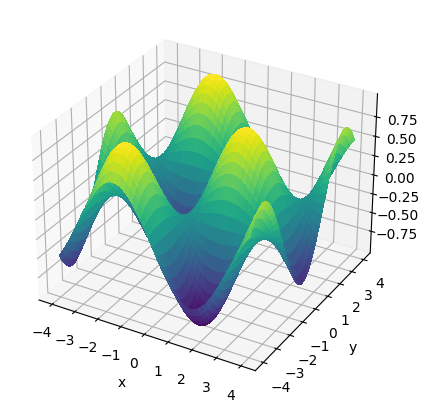

In [5]:
from mpl_toolkits import mplot3d

x = np.outer(np.linspace(-4, 4, 500), np.ones(500))
y = x.copy().T
f = np.sin(x)*np.cos(y)

fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection='3d')

surf = ax.plot_surface(x,y,f, 
                       cmap='viridis',
                       linewidth=0, 
                       antialiased=False)
plt.xlabel('x');
plt.ylabel('y');

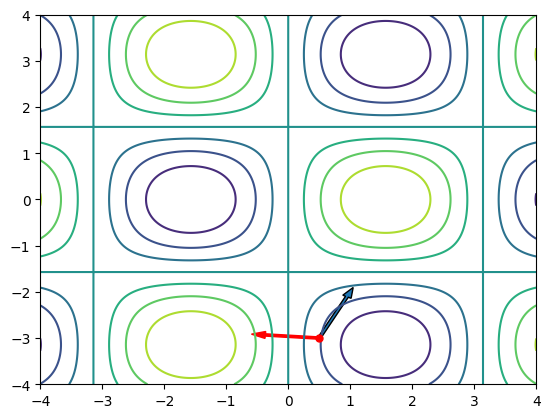

In [7]:
# plot contour lines of f(x,y)
plt.contour(x,y,f)
# plot our point 
plt.plot(0.5, -3, '.', c='red', markersize=10)
# create u (normalized)
u = np.array([0.5,1])/np.linalg.norm([0.5,1])
# plot u
plt.arrow(0.5, -3, u[0], u[1], width = 0.05) 
# plot gradient (in red)
plt.arrow(0.5,-3, ga.item(), gb.item(), width = 0.05, fc='red', ec='red');

---

## Gradient descent 

### Introductory example

Below is a simple example of how **gradient descent** works. In this example, we are finding the minimum of the function

$$ f(x) = x^2$$

Obviously, doing this with gradient descent is somewhat stupid, but it illustrates the concept. We start at $x^{(0)}=4$ (our initial value), $f(x^{(0)})=16$ and then update our position according to the **gradient descent update rule**:

<font color='blue'>
$$ x^{(t+1)} = x^{(t)} - \eta \nabla f(x^{(t)})$$ 
</font>

where $x^{(t)}$ denotes the value of $x$ in the $t$-th iteration of gradient descent. In our example, $\eta = 0.1$ and we iterate for 100 times. **Terminology**: $\eta$ is typically referred to as the step-size or the **learning rate**.

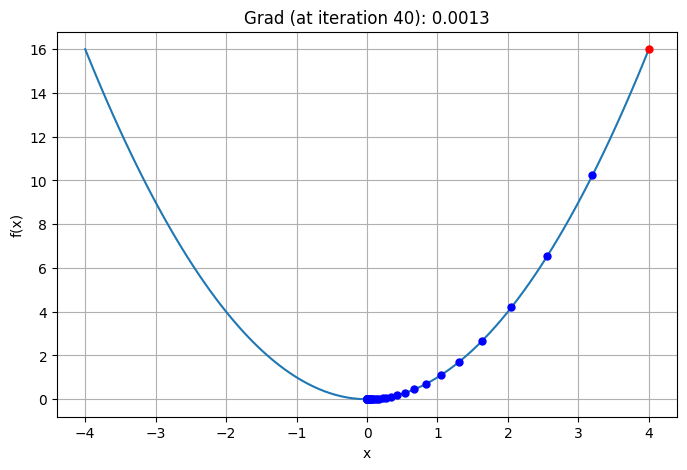

In [23]:
# for plotting; create 100 values evenly spaced in [-1,1]
a = np.linspace(-4,4,100)

plt.figure(figsize=(8,5))
plt.plot(a, np.power(a,2.))

at = 4.0 # start
lr = 0.1 # eta, aka. learning rate

# plot initial position (x^0,f(x^0))
plt.plot(at,np.power(at,2.0),'r.',markersize=10)

# iterate 40 times
for i in np.arange(1,40+1):
    
    # create a tensor
    x = torch.tensor([at], requires_grad=True)
    # compute f(x)
    y = torch.pow(x,2.)
    # compute gradient
    grad_x = grad(y,x)[0].item()
    # update rule
    at = at - lr*grad_x
    # plot updated position
    plt.plot(at, np.power(at,2.0),'b.',markersize=10)
plt.grid()

# print out the LAST gradient (should be approx. 0, as
# we should have found the minimum by then!
plt.title('Grad (at iteration {}): {:.4f}'.format(i,grad_x))
plt.xlabel('x');
plt.ylabel(r'f(x)');

### A more interesting example

In the following example, we compute the minimum of

$$z = f(x,y) = 0.5x^2 + x + 0.25y^2 - 2$$

using (1) PyTorch's `grad` function and, alternatively, (2) using `.backward()`.


In [8]:
import math
import numpy as np
from mpl_toolkits.mplot3d import axes3d, Axes3D
from matplotlib import cm

def func(xv, yv):
    return 0.5*xv**2 + xv + 0.25*yv**2 - 2

First, lets plot the function graph ...

In [9]:
X = np.linspace(-2.5, 2.6, 51)
Y = np.linspace(-2.5, 2.6, 51)
X, Y = np.meshgrid(X, Y)
Z = func(X,Y)

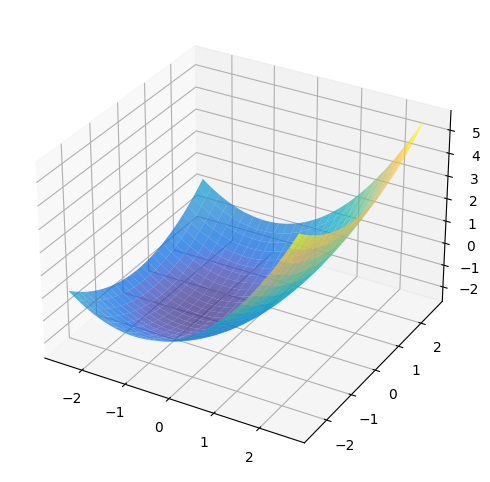

In [10]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, 
                Y, 
                Z, 
                cmap=parula_map, 
                linewidth=2, 
                antialiased=True, 
                alpha=0.7);

### Variant 1 - using `grad`

In [14]:
at = [2.0,-2.0] # starting point
lr = 0.25        # eta, aka. learning rate (our eta from before)

track = []
for i in np.arange(50):
    
    pts = torch.tensor(at, requires_grad=True)
    
    x = pts[0]
    y = pts[1]
    
    f = 0.5*torch.pow(x, 2.) + x + 0.25*torch.pow(y, 2.) - 2
    
    grad_x, grad_y = grad(f, (x, y))
    
    with torch.no_grad():
        x = (x - lr*grad_x).item()
        y = (y - lr*grad_y).item()

    at = [x, y]
    track.append([x,y,func(x,y)])

print('Result: ', at)

Result:  [-0.9999983310699463, -0.002520187059417367]


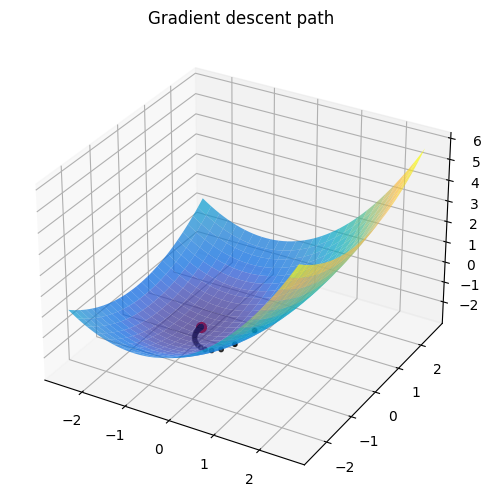

In [15]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, 
                Y, 
                Z, 
                cmap=parula_map, 
                linewidth=2, 
                antialiased=True, 
                alpha=0.7);

track = np.array(track)
ax.scatter(track[:-1,0],
           track[:-1,1],
           track[:-1,2],
           color="k",s=10);

track = np.array(track)
ax.scatter(track[-1,0],
           track[-1,1],
           track[-1,2],
           color="r",s=50);

ax.set_title('Gradient descent path');

### Variant 2 - using `backward`

In [38]:
at = [2.0,-2.0]
lr = 0.1 

for i in np.arange(200):
    # input data
    pts = torch.tensor(at, requires_grad=True)
    
    # compute f
    f = 0.5*torch.pow(pts[0], 2.) + pts[0] + 0.25*torch.pow(pts[1], 2.) - 2
    # compute gradients
    u = f.backward()

    # gradient descend update rule
    with torch.no_grad():
        pts = pts - lr*pts.grad #lr ... step-size aka learning rate
        
    # compute new position
    at = pts.detach().numpy()

print('Result: ', at)  

Result:  [-9.9999976e-01 -7.0105314e-05]


### Variant 3 - using `backward` and an optimizer

Ok, there is an even shorter variant ...

In [39]:
at = torch.tensor([-2.,2.], requires_grad=True)
opt = torch.optim.SGD([at], lr=0.1) # we will see this later

for i in np.arange(200):
    opt.zero_grad() # set all gradients to zero
    f = 0.5*torch.pow(at[0], 2.) + at[0] + 0.25*torch.pow(at[1],2.) - 2 # forward pass
    u = f.backward()  # gradient computation
    opt.step()        # parameter update
    
print('Result: ', at.detach().numpy())

Result:  [-1.0000005e+00  7.0105314e-05]


The function `Tensor.backward()` accumulates gradients in the `grad` fields of
tensors which are not results of operations, the “leaves” in the autograd graph.